# Intro

In [ ]:
!pip install nlp transformers datasets wandb
!apt install git-lfs

     |████████████████████████████████| 1.7 MB 14.7 MB/s 
     |████████████████████████████████| 3.5 MB 63.0 MB/s 
     |████████████████████████████████| 311 kB 66.2 MB/s 
     |████████████████████████████████| 1.7 MB 58.2 MB/s 
     |████████████████████████████████| 243 kB 76.2 MB/s 
     |████████████████████████████████| 596 kB 73.0 MB/s 
     |████████████████████████████████| 6.8 MB 50.9 MB/s 
     |████████████████████████████████| 895 kB 55.8 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
     |████████████████████████████████| 133 kB 77.4 MB/s 
     |████████████████████████████████| 97 kB 10.2 MB/s 
     |████████████████████████████████| 143 kB 72.9 MB/s 
     |████████████████████████████████| 180 kB 69.0 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
     |████████████████████████████████| 94 kB 4.8 MB/s 
     |████████████████████████████████| 271 kB 76.1 MB/s 
     |███████████████

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
## IMPORTS
import os
import sys
import logging
from dataclasses import dataclass, field
import json
from typing import Dict, List, Optional

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import datasets

from transformers import AutoModelForQuestionAnswering, AutoTokenizer
from transformers import default_data_collator, TrainingArguments, Trainer, EvalPrediction, set_seed


In [ ]:
# MONITOR CPU and GPU

os.environ["WANDB_DISABLED"] = "true"

# os.environ["WANDB_DISABLED"] = "false"
# import wandb
# wandb.init()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# GLOBAL VARIABLES

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

UNKNOWN = "unknown"
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert"

DATASET_TRAIN_DIR = "/content/drive/MyDrive/Colab Notebooks/seminar/dataset/coqa_train_ds_512_tokenized"
DATASET_TEST_DIR = "/content/drive/MyDrive/Colab Notebooks/seminar/dataset/coqa_val_ds_512_tokenized"

MODEL_NAME = "bert-base-uncased"
MY_MLM_MODEL_NAME = f"{MODEL_NAME}-pretrained-mlm-coqa-stories"
MY_QA_MODEL_NAME = f"{MODEL_NAME}-pretrain-finetuned-coqa-falttened"
MY_MLM_MODEL_PATH = f"alistvt/{MY_MLM_MODEL_NAME}"

SEED = 7

MAX_LENGTH = 512

In [ ]:
print(device)

LOGS_DIR = os.path.join(BASE_DIR, "logs/")
MODEL_DIR = os.path.join(BASE_DIR, "model/")
OUTPUT_DIR = os.path.join(BASE_DIR, "output/")
TOKENIZER_DIR = os.path.join(BASE_DIR, "tokenizer/")
ANSWERS_DIR = os.path.join(BASE_DIR, "answers/")

DIRECTORIES = [LOGS_DIR, MODEL_DIR, OUTPUT_DIR, TOKENIZER_DIR]

for direc in DIRECTORIES:
    if not os.path.exists(direc):
        os.makedirs(direc)
        print(direc)

cuda


# Prepare Data

In [ ]:
ds_train = datasets.load_from_disk(DATASET_TRAIN_DIR)
ds_val = datasets.load_from_disk(DATASET_TEST_DIR)

ds_train, ds_val

# cache the dataset, so we can load it directly for training

torch.save(ds_train, 'train_data.pt')
torch.save(ds_val, 'valid_data.pt')

# Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MY_MLM_MODEL_PATH)
data_collator = default_data_collator

Some weights of the model checkpoint at alistvt/bert-base-uncased-pretrained-mlm-coqa-stories were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at alistvt/ber

# Training script

In [ ]:
model = model.to(device)
set_seed(SEED)

In [ ]:
training_args = TrainingArguments(
    MY_QA_MODEL_NAME,
    
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=2000,

    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    save_steps=2000,
    load_best_model_at_end=True,

    num_train_epochs=3,

    weight_decay=0.01,
    push_to_hub=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Cloning https://huggingface.co/alistvt/bert-base-uncased-pretrain-finetuned-coqa-falttened into local empty directory.


In [ ]:
trainer.train(resume_from_checkpoint=True)
trainer.push_to_hub(commit_message="finetuining on Coqa 3 epochs.")
# trainer.train()
# trainer.save_model()

Loading model from bert-base-uncased-pretrain-finetuned-coqa-falttened/checkpoint-12000).
***** Running training *****
  Num examples = 108647
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 20373
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 12000
  Will skip the first 1 epochs then the first 5209 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/5209 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss
14000,2.128500,2.858836
16000,2.056900,2.893700
18000,2.079400,2.851141
20000,2.067900,2.865509


***** Running Evaluation *****
  Num examples = 7983
  Batch size = 16
Saving model checkpoint to bert-base-uncased-pretrain-finetuned-coqa-falttened/checkpoint-14000
Configuration saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/checkpoint-14000/config.json
Model weights saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/checkpoint-14000/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/checkpoint-14000/tokenizer_config.json
Special tokens file saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/checkpoint-14000/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/tokenizer_config.json
Special tokens file saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 7983
  Batch size = 16
Saving model checkpoint to bert-base-uncased-pretrain-finetuned-coqa-falttened/checkpoint-1600

Step,Training Loss,Validation Loss
14000,2.128500,2.858836
16000,2.056900,2.893700
18000,2.079400,2.851141
20000,2.067900,2.865509




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert-base-uncased-pretrained-mlm-coqa-stories-pretrain-finetuned-coqa-falttened/checkpoint-12000 (score: 2.7381863594055176).
Could not locate the best model at bert-base-uncased-pretrained-mlm-coqa-stories-pretrain-finetuned-coqa-falttened/checkpoint-12000/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.
Saving model checkpoint to bert-base-uncased-pretrain-finetuned-coqa-falttened
Configuration saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/config.json
Model weights saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/tokenizer_config.json
Special tokens file saved in bert-base-uncased-pretrain-finetuned-coqa-falttened/special_tokens_map.json
Several commits (2) will be pushed upstr

Upload file pytorch_model.bin:   0%|          | 3.35k/415M [00:00<?, ?B/s]

Upload file runs/Jan22_02-41-19_5e06f00e3605/events.out.tfevents.1642819466.5e06f00e3605.3137.0:  46%|####6   …

To https://huggingface.co/alistvt/bert-base-uncased-pretrain-finetuned-coqa-falttened
   75a4846..950cc87  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}}
To https://huggingface.co/alistvt/bert-base-uncased-pretrain-finetuned-coqa-falttened
   950cc87..b260073  main -> main



'https://huggingface.co/alistvt/bert-base-uncased-pretrain-finetuned-coqa-falttened/commit/950cc87aa50b725f2e2c2ca53c3e06ccdf3493dc'

In [ ]:
# Evaluation
results = {}
    
eval_output = trainer.evaluate()

output_eval_file = os.path.join(training_args.output_dir, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(eval_output.keys()):
        print("  %s = %s"% (key, str(eval_output[key])))

results.update(eval_output)

print(results)


***** Running Evaluation *****
  Num examples = 7983
  Batch size = 16


***** Eval results *****
  epoch = 2.0
  eval_loss = 2.7381863594055176
  eval_runtime = 144.1709
  eval_samples_per_second = 55.372
  eval_steps_per_second = 3.461
{'eval_loss': 2.7381863594055176, 'eval_runtime': 144.1709, 'eval_samples_per_second': 55.372, 'eval_steps_per_second': 3.461, 'epoch': 2.0}


In [ ]:
tokenizer.save_pretrained(MODEL_DIR)

tokenizer config file saved in /content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/special_tokens_map.json


('/content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/tokenizer.json')

In [ ]:
trainer.save_model(output_dir=MODEL_DIR)

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/
Configuration saved in /content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab Notebooks/seminar/pretrained-finetuning-bert/model/special_tokens_map.json


In [ ]:
trainer.push_to_hub(MODEL_DIR)

Saving model checkpoint to bert-base-uncased-pretrained-mlm-coqa-stories-pretrain-finetuned-coqa-falttened
Configuration saved in bert-base-uncased-pretrained-mlm-coqa-stories-pretrain-finetuned-coqa-falttened/config.json
Model weights saved in bert-base-uncased-pretrained-mlm-coqa-stories-pretrain-finetuned-coqa-falttened/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-pretrained-mlm-coqa-stories-pretrain-finetuned-coqa-falttened/tokenizer_config.json
Special tokens file saved in bert-base-uncased-pretrained-mlm-coqa-stories-pretrain-finetuned-coqa-falttened/special_tokens_map.json


AttributeError: ignored

# Test model with data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MY_QA_MODEL_NAME)
model.to(device)

Downloading:   0%|          | 0.00/709 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
!nvidia-smi

Thu Jan 27 21:28:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |   1635MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
len(ds_val)

7983

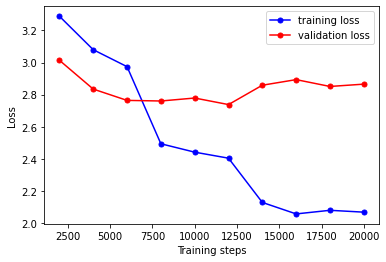

In [ ]:
t = [i for i in range(2000, 22000, 2000)]
train_loss = [3.2886, 3.0801, 2.9744, 2.494, 2.4417, 2.4042, 2.1285, 2.0569, 2.0794, 2.0679]
validation_loss = [3.0142, 2.8347, 2.7643, 2.7605, 2.7790, 2.7382, 2.8588, 2.8937, 2.8511, 2.8655]

from matplotlib import pyplot as plt

plt.plot(t, train_loss, 'o', color='b', label='training loss', ls='-', ms=5, markevery=1)
plt.plot(t, validation_loss, 'o', color='r', label='validation loss', ls='-', ms=5, markevery=1)
plt.legend(loc='best')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [ ]:
from transformers import pipeline
question_answering = pipeline("question-answering", model=model.to(device), tokenizer=tokenizer, device=0)

def make_predictions():
    df_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/seminar/dataset/coqa_flat_val_df.pkl")
    ds_val = datasets.Dataset.from_pandas(df_test)

    predictions = []

    for item in tqdm(ds_val):
        question, text = item["question"], item["story"]

        result = question_answering(question=question, context=text)

        answer = result['answer']
        
        predictions.append(
            {
                "id": item["id"],
                "turn_id": item["turn_id"],
                "answer": answer
            }
        )
    return predictions

predictions = make_predictions()

with open("answers.json", 'w') as f:
    f.write(json.dumps(predictions))

  0%|          | 0/7983 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:978: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
! python "/content/drive/MyDrive/Colab Notebooks/seminar/evaluate-v1.1.py" --data-file "/content/drive/MyDrive/Colab Notebooks/seminar/dataset/coqa-dev-v1.0.json" --pred-file "answers.json"

{
  "children_stories": {
    "em": 45.6,
    "f1": 69.6,
    "turns": 1425
  },
  "literature": {
    "em": 34.7,
    "f1": 57.3,
    "turns": 1630
  },
  "mid-high_school": {
    "em": 37.7,
    "f1": 61.1,
    "turns": 1653
  },
  "news": {
    "em": 35.2,
    "f1": 61.8,
    "turns": 1649
  },
  "wikipedia": {
    "em": 43.9,
    "f1": 70.8,
    "turns": 1626
  },
  "reddit": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "science": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "in_domain": {
    "em": 39.3,
    "f1": 64.0,
    "turns": 7983
  },
  "out_domain": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "overall": {
    "em": 39.3,
    "f1": 64.0,
    "turns": 7983
  }
}
